# 한강공원(여의도) 주차 혼잡도(여유,보통,혼잡,매우혼잡) 예측

---
## 사용 데이터
    서울시 한강공원 일별 데이터 사용(2020~2024)

In [98]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
han_River = pd.read_csv("../../Data/한강공원 주차장 일별 이용 현황.csv",encoding='euc-kr')

---;
## 데이터 전처리

### 여의도 한강공원 데이터 추출

    주차장 별 주차구획수(계):
    여의도1주차장 - 462
    여의도2주차장 - 176
    여의도3주차장 - 785
    여의도4주차장 - 218
    여의도5주차장 - 141

In [99]:
# PLT-008(여의도 한강공원)
han_River = han_River[han_River['지구별'] == 'PLT-008'].sort_index(ignore_index=True)

### 데이터 구조 확인
    컬럼의 이름, 데이터 유형, 결측치 여부를 확인하여 데이터의 기본 구조를 파악

In [100]:
# 데이터 head
han_River.head()

,지구별,주차장명,주차대수,이용시간,날짜
0,PLT-008,여의도5주차장,229,22509,2024/11/10
1,PLT-008,여의도2주차장,1934,150135,2024/11/10
2,PLT-008,여의도1주차장,3398,355119,2024/11/10
3,PLT-008,여의도4주차장,41,1994,2024/11/10
4,PLT-008,여의도3주차장,2326,318649,2024/11/10


In [101]:
# 데이터 tail
han_River.tail()

,지구별,주차장명,주차대수,이용시간,날짜
8675,PLT-008,여의도1주차장,1541,172802,2020/01/18
8676,PLT-008,여의도1주차장,1113,255747,2020/01/17
8677,PLT-008,여의도1주차장,873,221484,2020/01/16
8678,PLT-008,여의도1주차장,114,6073,2020/01/15
8679,PLT-008,여의도1주차장,2,0,2020/01/14


In [102]:
# 데이터 정보 확인
han_River.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8680 entries, 0 to 8679
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   지구별     8680 non-null   object
 1   주차장명    8680 non-null   object
 2   주차대수    8680 non-null   int64 
 3   이용시간    8680 non-null   int64 
 4   날짜      8680 non-null   object
dtypes: int64(2), object(3)
memory usage: 339.2+ KB


> NaN값이 없는 것을 확인 할 수 있다.

In [103]:
# 기초 통계 확인
han_River.describe()

,주차대수,이용시간
count,8680.000000,8680.000000
mean,1039.982488,171226.257143
std,996.637386,133462.043181
min,1.000000,0.000000
25%,255.000000,69112.000000
50%,821.500000,130141.000000
75%,1465.000000,270569.000000
max,7424.000000,646550.000000


> 주차장 주차구획수가 없으므로 컬럼 추가

In [104]:
# 주차장별 총 주차 가능 대수
total_parking_capacity = {
    '여의도1주차장': 462,
    '여의도2주차장': 176,
    '여의도3주차장': 785,
    '여의도4주차장': 218,
    '여의도5주차장': 141,
}

# '주차장명'을 기준으로 '주차구획수' 컬럼 추가
han_River['주차구획수'] = han_River['주차장명'].map(total_parking_capacity)

# 확인
han_River[['주차장명', '주차구획수']].head()

,주차장명,주차구획수
0,여의도5주차장,141
1,여의도2주차장,176
2,여의도1주차장,462
3,여의도4주차장,218
4,여의도3주차장,785


### 휴일여부 및 요일 추가

In [105]:
han_River

,지구별,주차장명,주차대수,이용시간,날짜,주차구획수
0,PLT-008,여의도5주차장,229,22509,2024/11/10,141
1,PLT-008,여의도2주차장,1934,150135,2024/11/10,176
2,PLT-008,여의도1주차장,3398,355119,2024/11/10,462
3,PLT-008,여의도4주차장,41,1994,2024/11/10,218
4,PLT-008,여의도3주차장,2326,318649,2024/11/10,785
...,...,...,...,...,...,...
8675,PLT-008,여의도1주차장,1541,172802,2020/01/18,462
8676,PLT-008,여의도1주차장,1113,255747,2020/01/17,462
8677,PLT-008,여의도1주차장,873,221484,2020/01/16,462
8678,PLT-008,여의도1주차장,114,6073,2020/01/15,462


In [106]:
# 날짜 컬럼을 날짜 형식으로 전환
han_River['날짜'] = pd.to_datetime(han_River['날짜'], format= '%Y/%m/%d')

# 월별로 차이를 알기 위해 연도,월,일별 컬럼 추가
han_River['연도'] = han_River['날짜'].dt.year
han_River['월'] = han_River['날짜'].dt.month
han_River['일'] = han_River['날짜'].dt.day

In [107]:
import holidays

# 대한민국 공휴일 불러오기
kr_holidays = holidays.KR(years=range(2020,2025))

# 요일 숫자를 요일 이름으로 변환
han_River['요일'] = han_River['날짜'].dt.weekday

# 공휴일 체크
han_River['휴일여부'] = han_River['날짜'].apply(lambda x: 2 if x in kr_holidays else (1 if x.weekday() >= 5 else 0))

# 데이터 확인
han_River

,지구별,주차장명,주차대수,이용시간,날짜,주차구획수,연도,월,일,요일,휴일여부
0,PLT-008,여의도5주차장,229,22509,2024-11-10,141,2024,11,10,6,1
1,PLT-008,여의도2주차장,1934,150135,2024-11-10,176,2024,11,10,6,1
2,PLT-008,여의도1주차장,3398,355119,2024-11-10,462,2024,11,10,6,1
3,PLT-008,여의도4주차장,41,1994,2024-11-10,218,2024,11,10,6,1
4,PLT-008,여의도3주차장,2326,318649,2024-11-10,785,2024,11,10,6,1
...,...,...,...,...,...,...,...,...,...,...,...
8675,PLT-008,여의도1주차장,1541,172802,2020-01-18,462,2020,1,18,5,1
8676,PLT-008,여의도1주차장,1113,255747,2020-01-17,462,2020,1,17,4,0
8677,PLT-008,여의도1주차장,873,221484,2020-01-16,462,2020,1,16,3,0
8678,PLT-008,여의도1주차장,114,6073,2020-01-15,462,2020,1,15,2,0


### 평균 이용시간 추가

In [108]:
# 한글 폰트 문제 해결 
# matplotlib은 한글 폰트를 지원하지 않음
# os정보
import platform
import matplotlib.pyplot as plt

# font_manager : 폰트 관리 모듈
# rc : 폰트 변경 모듈
from matplotlib import font_manager, rc
# unicode 설정
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic') # os가 macos
elif platform.system() == 'Windows':
    path = 'c:/Windows/Fonts/malgun.ttf' # os가 windows
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print("Unknown System")

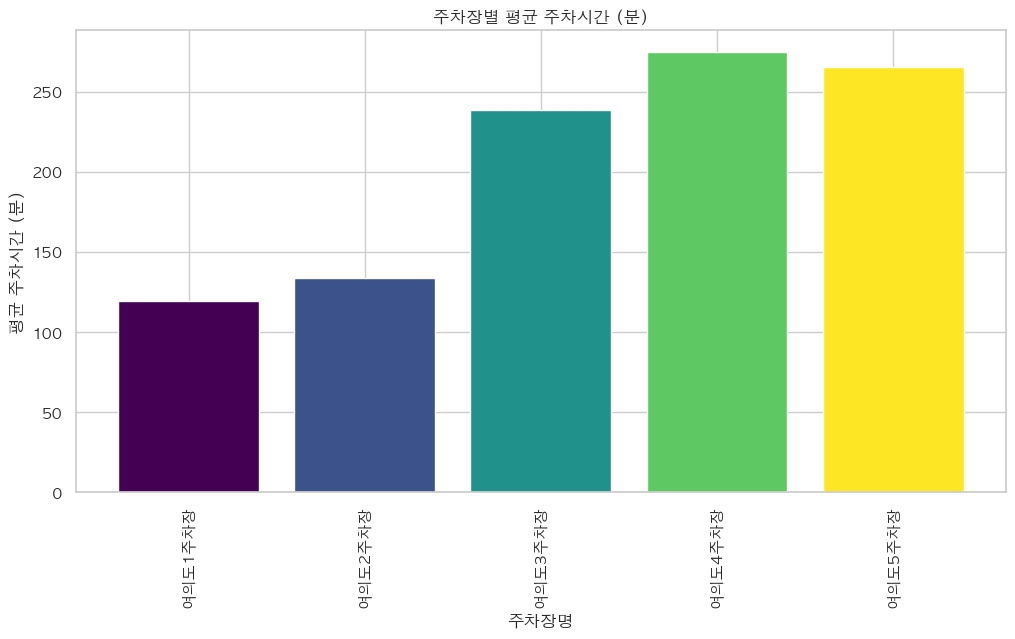

In [109]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# 주차장별 평균 주차시간을 계산
avg_parking_time = han_River.groupby('주차장명').apply(lambda x: x['이용시간'].sum() / x['주차대수'].sum())
avg_parking_time = avg_parking_time.reset_index()
avg_parking_time.columns = ['주차장명', '평균_주차시간(분)']

# 그래프 그리기
plt.figure(figsize=(12, 6))

# 컬러맵에서 색상 가져오기
colors = cm.get_cmap('viridis', len(avg_parking_time))

# 바 그래프 그리기 (각 바마다 다른 색상 적용)
bars = plt.bar(avg_parking_time['주차장명'], avg_parking_time['평균_주차시간(분)'], color=[colors(i) for i in range(len(avg_parking_time))])

plt.title('주차장별 평균 주차시간 (분)')
plt.xlabel('주차장명')
plt.ylabel('평균 주차시간 (분)')
plt.xticks(rotation=90)
plt.show()

> 

### 교통량 정보 불러오기

> 데이터가 일별 누적 주차대수밖에 없으므로 교통량을 불러와 일별 누적 추자대수를 교통량을 기준으로 시간대별로 나눠줘야함.        
2020년 01월 ~ 2024 09월 까지 데이터 수집

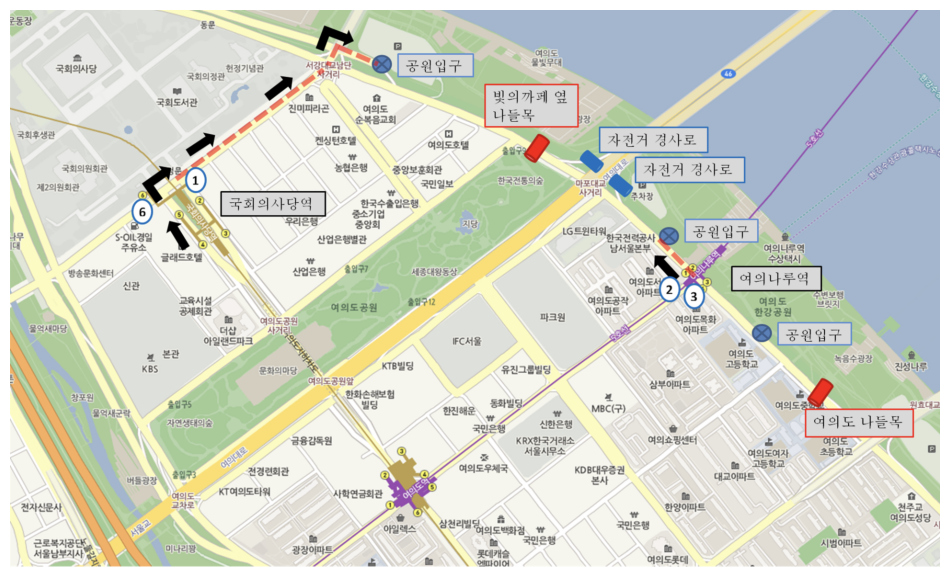

In [110]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 이미지 읽기
img = mpimg.imread('../../Data/올림픽대로 유입.png')

# 이미지 표시
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')  # 축 제거
plt.show()

### 올림픽대로와 한강공원의 유입/유출 관계
    유입:
    올림픽대로에서 여의도 한강공원으로 들어가는 차량의 경로를 "유입"으로 간주할 수 있습니다.
    지도에서 "공원입구"와 "자전거 경사로" 등으로 표기된 지점이 한강공원으로의 유입 지점으로 보입니다.

    유출:
    한강공원 주차장에서 나와 올림픽대로로 진입하는 차량은 "유출"에 해당합니다.
    여의도 한강공원에서 올림픽대로로의 나들목은 유출 경로로 작용합니다.

**따라서 한강공원의 주차대수를 예측하기 위해서 올림픽대로의 유입 교통량을 사용하여 예측하는 것이 바람직합니다.**

In [111]:
# import os
# import pandas as pd

# # 데이터가 저장된 최상위 폴더 경로
# base_folder = '../../Data/Traffic_volume'

# # 빈 리스트 생성
# dataframes = []

# # 폴더 내 모든 파일 탐색
# for root, dirs, files in os.walk(base_folder):
#     for file in files:
#         if file.endswith('.xlsx'):  # 엑셀 파일만 처리
#             file_path = os.path.join(root, file)
#             print(f"Processing file: {file_path}")  # 현재 처리 중인 파일 출력
            
#             # 엑셀 파일 읽기
#             try:
#                 df = pd.read_excel(file_path)
#             except Exception as e:
#                 print(f"Error reading {file_path}: {e}")
#                 continue
            
#             # 필요한 컬럼만 선택
#             if '지점명' in df.columns and '일자' in df.columns:
#                 traffic_columns = ['지점명', '일자', '방향'] + [f'{i}시' for i in range(24) if f'{i}시' in df.columns]
#                 df = df[traffic_columns]
                
#                 # "지점명"이 "올림픽대로"인 데이터만 필터링
#                 df_filtered = df[(df['지점명'] == '올림픽대로') & (df['방향'] == '유입')]
                
#                 if not df_filtered.empty:
#                     print(f"Rows added from {file_path}: {len(df_filtered)}")
#                     dataframes.append(df_filtered)
#             else:
#                 print(f"Missing key columns in {file_path}, skipping...")

# # 데이터프레임 병합
# if dataframes:
#     combined_df = pd.concat(dataframes, ignore_index=True)
#     combined_df.to_csv('./올림픽대로 교통량.csv', index=False)
#     print("Combined data saved to './올림픽대로 교통량.csv'")
# else:
#     print("No data to combine. Exiting...")


In [112]:
traffic = pd.read_csv('../../Data/Traffic_volume/올림픽대로 교통량.csv').sort_values(by='일자', ascending=True).reset_index(drop=True)
traffic

,지점명,일자,방향,0시,1시,2시,3시,4시,5시,6시,...,14시,15시,16시,17시,18시,19시,20시,21시,22시,23시
0,올림픽대로,20200101,유입,4102.0,4841.0,2986.0,2096.0,2099.0,2435.0,2601.0,...,6890.0,6973.0,7106.0,6215.0,5520.0,5298.0,5637.0,5364.0,4567.0,2921.0
1,올림픽대로,20200102,유입,2048.0,1254.0,1097.0,1069.0,1631.0,3393.0,6460.0,...,7586.0,7710.0,7830.0,7787.0,6200.0,6087.0,6299.0,6175.0,5935.0,4738.0
2,올림픽대로,20200103,유입,2778.0,2731.0,2072.0,1726.0,2129.0,3420.0,5990.0,...,7886.0,7309.0,7851.0,7656.0,6476.0,6195.0,6440.0,7089.0,6635.0,5552.0
3,올림픽대로,20200104,유입,4451.0,3548.0,2800.0,2323.0,2514.0,3204.0,4233.0,...,7736.0,7412.0,7567.0,7203.0,6876.0,6206.0,5876.0,6065.0,5663.0,4446.0
4,올림픽대로,20200105,유입,3409.0,2542.0,1902.0,1588.0,1817.0,2114.0,2766.0,...,7569.0,7469.0,7694.0,7133.0,6519.0,5750.0,5900.0,5727.0,4965.0,3347.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1730,올림픽대로,20240926,유입,4105.0,2755.0,2094.0,1839.0,2554.0,4467.0,6829.0,...,7134.0,6465.0,6443.0,5898.0,5853.0,6199.0,7014.0,6589.0,6959.0,5740.0
1731,올림픽대로,20240927,유입,4677.0,3125.0,2376.0,2047.0,2619.0,4460.0,6885.0,...,6797.0,6826.0,6391.0,5852.0,5191.0,5957.0,6743.0,6594.0,6506.0,6686.0
1732,올림픽대로,20240928,유입,5985.0,3844.0,2779.0,2406.0,2881.0,4017.0,5208.0,...,6110.0,6258.0,6139.0,6047.0,6076.0,6408.0,6103.0,6180.0,6314.0,5197.0
1733,올림픽대로,20240929,유입,3962.0,2778.0,2157.0,1732.0,2121.0,2970.0,4098.0,...,6355.0,6546.0,6294.0,6499.0,5854.0,6070.0,5956.0,6805.0,6200.0,3984.0


> 한강 데이터의 날짜가 Date type이므로 일자 type변경

In [113]:
traffic['일자'] = pd.to_datetime(traffic['일자'], format='%Y%m%d')

In [114]:
# 한강 데이터와 일자 맞추기
# 2020년 1월 14일부터 2024년 9월 30일까지의 데이터 추출 

# 시작일
start_date = '2020-01-14'
# 종료일
end_date = '2024-9-30'

# 날짜 추출
traffic = traffic[traffic['일자'].between(start_date, end_date)]
han_River = han_River[han_River['날짜'].between(start_date, end_date)]

# 결과확인
print(traffic.head())
print('*' * 100, '\n')
print(han_River.head())

      지점명         일자  방향      0시      1시      2시      3시      4시      5시  \
13  올림픽대로 2020-01-14  유입  3612.0  2586.0  1914.0  1737.0  1923.0  3425.0   
14  올림픽대로 2020-01-15  유입  3913.0  2778.0  2062.0  1756.0  2093.0  3524.0   
15  올림픽대로 2020-01-16  유입  4120.0  2924.0  2182.0  1885.0  2011.0  3507.0   
16  올림픽대로 2020-01-17  유입  4324.0  3048.0  2287.0  1953.0  2199.0  3592.0   
17  올림픽대로 2020-01-18  유입  5216.0  3847.0  3240.0  2455.0  2566.0  3431.0   

        6시  ...     14시     15시     16시     17시     18시     19시     20시  \
13  6221.0  ...  8041.0  7616.0  7835.0  7725.0  7090.0  6607.0  6165.0   
14  6084.0  ...  7027.0  7826.0  7584.0  7487.0  6584.0  6429.0  6447.0   
15  6328.0  ...  7443.0  7749.0  7836.0  7395.0  6690.0  6634.0  6372.0   
16  6208.0  ...  7265.0  7538.0  7954.0  7527.0  6499.0  6383.0  6505.0   
17  4389.0  ...  7657.0  7512.0  7202.0  7366.0  7308.0  7054.0  6143.0   

       21시     22시     23시  
13  6970.0  6717.0  5277.0  
14  6602.0  6688.0  5318.0  
15  7

In [115]:
# 모든 방향은 유입이므로 컬럼 삭제 
traffic.drop(columns='방향', inplace=True)

In [116]:
# 일자 => 날짜, 지점명 => 도로명
traffic.rename(columns={'지점명': '도로명','일자': '날짜'}, inplace=True)

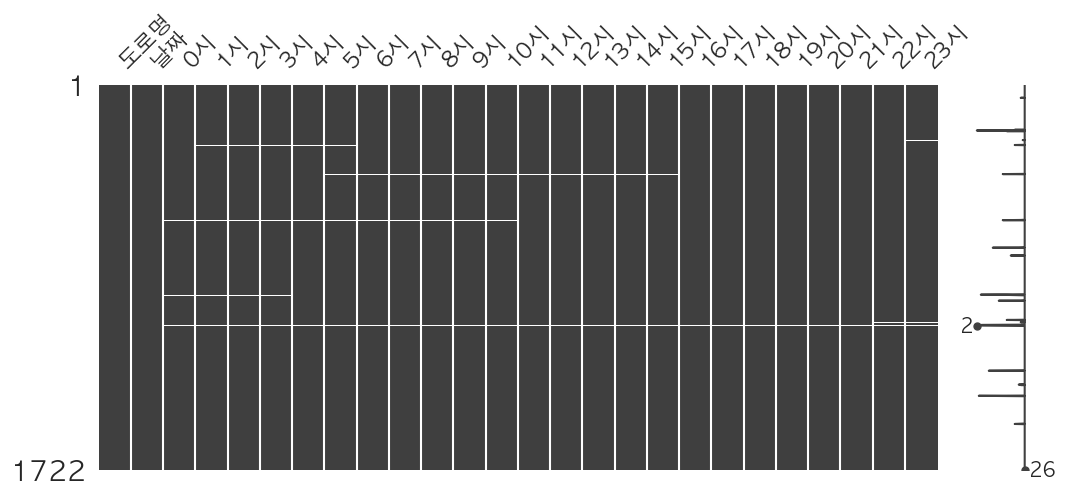

In [117]:
# 결측치 확인
import missingno as msno 

msno.matrix(traffic, figsize=(12, 5))
plt.show()

In [118]:
# 한강 데이터와 교통량 데이터 merge
df = pd.merge(han_River, traffic, how='left')

In [119]:
# 요일별 평균으로 NaN 값 채우기
columns_with_nan = ['0시', '1시', '2시', '3시', '4시', '5시', '6시', '7시', '8시', '9시',
                    '10시', '11시', '12시', '13시', '14시', '15시', '16시', '17시', '18시',
                    '19시', '20시', '21시', '22시', '23시']

# 각 요일별 평균 계산 후 NaN 값 채우기
for col in columns_with_nan:
    df[col] = df.groupby('요일')[col].transform(lambda x: x.fillna(x.mean()))

# NaN 처리 결과 확인
print(df[columns_with_nan].isnull().sum())

0시     0
1시     0
2시     0
3시     0
4시     0
5시     0
6시     0
7시     0
8시     0
9시     0
10시    0
11시    0
12시    0
13시    0
14시    0
15시    0
16시    0
17시    0
18시    0
19시    0
20시    0
21시    0
22시    0
23시    0
dtype: int64


> 결측치가 존재하는 것을 확인 할 수 있다.           
하지만 결측치의 개수가 많지 않으므로 같은 요일을 기준으로 $NaN$값을 요일별 **평균대치법**을 이용해 처리.

In [120]:
# 중간 저장
df.to_csv('../../Data/서울시 한강공원 주차대수 예측.csv')

### 교통량을 이용한 누적주차대수 분배

In [121]:
df['교통량 합계'] = df[
                   [
                   '6시', '7시', '8시', '9시', '10시', 
                   '11시', '12시', '13시', '14시', '15시', '16시', '17시',
                   '18시','19시', '20시', '21시', '22시', '23시', '0시'
                   ]
                   ].sum(axis=1)

### 주차대수 분배
    각 시간대 비율을 활용해 주차대수를 분배
$시간대별 주차대수 = 전체 주차대수 * 시간대비율$

In [122]:
# 아침, 낮, 저녁 시간대 열 정의
morning_columns = ['6시','7시','8시','9시','10시'] # 아침
afternoon_columns = ['11시','12시','13시','14시','15시','16시','17시'] # 낮
evening_columns = ['18시', '19시', '20시', '21시', '22시','23시','0시'] # 저녁

# 시간대별 교통량 합계 계산
df['아침 교통량 합계'] = df[morning_columns].sum(axis=1)
df['낮 교통량 합계'] = df[afternoon_columns].sum(axis=1)
df['저녁 교통량 합계'] = df[evening_columns].sum(axis=1)

# 시간대별 교통량 비율 계산
df['아침 교통량 비율'] = df['아침 교통량 합계'] / df['교통량 합계']
df['낮 교통량 비율'] = df['낮 교통량 합계'] / df['교통량 합계']
df['저녁 교통량 비율'] = df['저녁 교통량 합계'] / df['교통량 합계']

# 주차대수 분배
df['아침 주차대수'] = round(df['주차대수'] * df['아침 교통량 비율'],2)
df['낮 주차대수'] = round(df['주차대수'] * df['낮 교통량 비율'],2)
df['저녁 주차대수'] = round(df['주차대수'] * df['저녁 교통량 비율'],2)

In [123]:
df[[
                   '6시', '7시', '8시', '9시', '10시', 
                   '11시', '12시', '13시', '14시', '15시', '16시', '17시',
                   '18시','19시', '20시', '21시', '22시', '23시', '0시'
                   ]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8475 entries, 0 to 8474
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   6시      8475 non-null   float64
 1   7시      8475 non-null   float64
 2   8시      8475 non-null   float64
 3   9시      8475 non-null   float64
 4   10시     8475 non-null   float64
 5   11시     8475 non-null   float64
 6   12시     8475 non-null   float64
 7   13시     8475 non-null   float64
 8   14시     8475 non-null   float64
 9   15시     8475 non-null   float64
 10  16시     8475 non-null   float64
 11  17시     8475 non-null   float64
 12  18시     8475 non-null   float64
 13  19시     8475 non-null   float64
 14  20시     8475 non-null   float64
 15  21시     8475 non-null   float64
 16  22시     8475 non-null   float64
 17  23시     8475 non-null   float64
 18  0시      8475 non-null   float64
dtypes: float64(19)
memory usage: 1.2 MB


### 이용시간(누적) => 시간대별 이용시간

In [124]:
# 전체 주차대수 합계 계산 (아침, 낮, 저녁)
df['전체 시간대 주차대수'] = df['아침 주차대수'] + df['낮 주차대수'] + df['저녁 주차대수']

# 시간대별 주차대수 비율 계산
df['아침 비율'] = df['아침 주차대수'] / df['전체 시간대 주차대수']
df['낮 비율'] = df['낮 주차대수'] / df['전체 시간대 주차대수']
df['저녁 비율'] = df['저녁 주차대수'] / df['전체 시간대 주차대수']

# 시간대별 이용시간 계산
df['아침 이용시간'] = df['이용시간'] * df['아침 비율']
df['낮 이용시간'] = df['이용시간'] * df['낮 비율']
df['저녁 이용시간'] = df['이용시간'] * df['저녁 비율']

# 결과 확인
df[['날짜', '주차장명', '이용시간', '아침 이용시간', '낮 이용시간', '저녁 이용시간']].head()

,날짜,주차장명,이용시간,아침 이용시간,낮 이용시간,저녁 이용시간
0,2024-09-30,여의도3주차장,407428,119921.907728,151763.007394,135743.084878
1,2024-09-30,여의도5주차장,102587,30193.775915,38212.977215,34180.246870
2,2024-09-30,여의도2주차장,201372,59270.689341,75010.012818,67091.297841
3,2024-09-30,여의도1주차장,450979,132739.981361,167986.340760,150252.677879
4,2024-09-30,여의도4주차장,69947,20587.848522,26056.118916,23303.032562


In [125]:
df.drop(columns=['전체 시간대 주차대수', '아침 비율', '낮 비율','저녁 비율'], inplace=True)

> 이제 교통량에 대한 정보는 필요없으므로 삭제해줌  =>  다중공선성 방지

In [126]:
df.columns

Index(['지구별', '주차장명', '주차대수', '이용시간', '날짜', '주차구획수', '연도', '월', '일', '요일',
       '휴일여부', '도로명', '0시', '1시', '2시', '3시', '4시', '5시', '6시', '7시', '8시',
       '9시', '10시', '11시', '12시', '13시', '14시', '15시', '16시', '17시', '18시',
       '19시', '20시', '21시', '22시', '23시', '교통량 합계', '아침 교통량 합계', '낮 교통량 합계',
       '저녁 교통량 합계', '아침 교통량 비율', '낮 교통량 비율', '저녁 교통량 비율', '아침 주차대수', '낮 주차대수',
       '저녁 주차대수', '아침 이용시간', '낮 이용시간', '저녁 이용시간'],
      dtype='object')

In [127]:
# 제거할 컬럼
columns_to_drop = ['0시','1시', '2시', '3시', '4시', '5시', '6시', '7시', '8시', '9시',
                   '10시', '11시', '12시', '13시', '14시', '15시', '16시', '17시',
                   '18시', '19시', '20시', '21시', '22시','23시',
                   '교통량 합계', '아침 교통량 합계', '낮 교통량 합계', '저녁 교통량 합계', '도로명',
                   '아침 교통량 비율', '낮 교통량 비율', '저녁 교통량 비율']

# 컬럼 제거
df.drop(columns=columns_to_drop, inplace=True)

# 결과 확인
df.head()

,지구별,주차장명,주차대수,이용시간,날짜,주차구획수,연도,월,일,요일,휴일여부,아침 주차대수,낮 주차대수,저녁 주차대수,아침 이용시간,낮 이용시간,저녁 이용시간
0,PLT-008,여의도3주차장,1558,407428,2024-09-30,785,2024,9,30,0,0,458.58,580.34,519.08,119921.907728,151763.007394,135743.084878
1,PLT-008,여의도5주차장,377,102587,2024-09-30,141,2024,9,30,0,0,110.96,140.43,125.61,30193.775915,38212.977215,34180.246870
2,PLT-008,여의도2주차장,2381,201372,2024-09-30,176,2024,9,30,0,0,700.81,886.91,793.28,59270.689341,75010.012818,67091.297841
3,PLT-008,여의도1주차장,3041,450979,2024-09-30,462,2024,9,30,0,0,895.08,1132.75,1013.17,132739.981361,167986.340760,150252.677879
4,PLT-008,여의도4주차장,203,69947,2024-09-30,218,2024,9,30,0,0,59.75,75.62,67.63,20587.848522,26056.118916,23303.032562


In [128]:
# 저장
df.to_csv('../../Data/서울시 한강공원 시간별 주차대수.csv')

---

In [129]:
import warnings
warnings.filterwarnings('ignore')

In [130]:
# import Packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 필수 라이브러리 설정
sns.set(style="whitegrid")
plt.rcParams['axes.labelsize'] = 12

In [131]:
df

,지구별,주차장명,주차대수,이용시간,날짜,주차구획수,연도,월,일,요일,휴일여부,아침 주차대수,낮 주차대수,저녁 주차대수,아침 이용시간,낮 이용시간,저녁 이용시간
0,PLT-008,여의도3주차장,1558,407428,2024-09-30,785,2024,9,30,0,0,458.58,580.34,519.08,119921.907728,151763.007394,135743.084878
1,PLT-008,여의도5주차장,377,102587,2024-09-30,141,2024,9,30,0,0,110.96,140.43,125.61,30193.775915,38212.977215,34180.246870
2,PLT-008,여의도2주차장,2381,201372,2024-09-30,176,2024,9,30,0,0,700.81,886.91,793.28,59270.689341,75010.012818,67091.297841
3,PLT-008,여의도1주차장,3041,450979,2024-09-30,462,2024,9,30,0,0,895.08,1132.75,1013.17,132739.981361,167986.340760,150252.677879
4,PLT-008,여의도4주차장,203,69947,2024-09-30,218,2024,9,30,0,0,59.75,75.62,67.63,20587.848522,26056.118916,23303.032562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8470,PLT-008,여의도1주차장,1541,172802,2020-01-18,462,2020,1,18,5,1,354.57,654.68,531.75,39760.159079,73413.376613,59628.464309
8471,PLT-008,여의도1주차장,1113,255747,2020-01-17,462,2020,1,17,4,0,299.44,441.87,371.69,68805.823612,101533.627035,85407.549353
8472,PLT-008,여의도1주차장,873,221484,2020-01-16,462,2020,1,16,3,0,238.22,348.38,286.41,60436.785925,88384.549914,72662.664162
8473,PLT-008,여의도1주차장,114,6073,2020-01-15,462,2020,1,15,2,0,30.55,46.38,37.07,1627.457456,2470.752105,1974.790439


## 상관관계

In [132]:
# 한글 폰트 문제 해결 
# matplotlib은 한글 폰트를 지원하지 않음
# os정보
import platform
import matplotlib.pyplot as plt

# font_manager : 폰트 관리 모듈
# rc : 폰트 변경 모듈
from matplotlib import font_manager, rc
# unicode 설정
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic') # os가 macos
elif platform.system() == 'Windows':
    path = 'c:/Windows/Fonts/malgun.ttf' # os가 windows
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print("Unknown System")

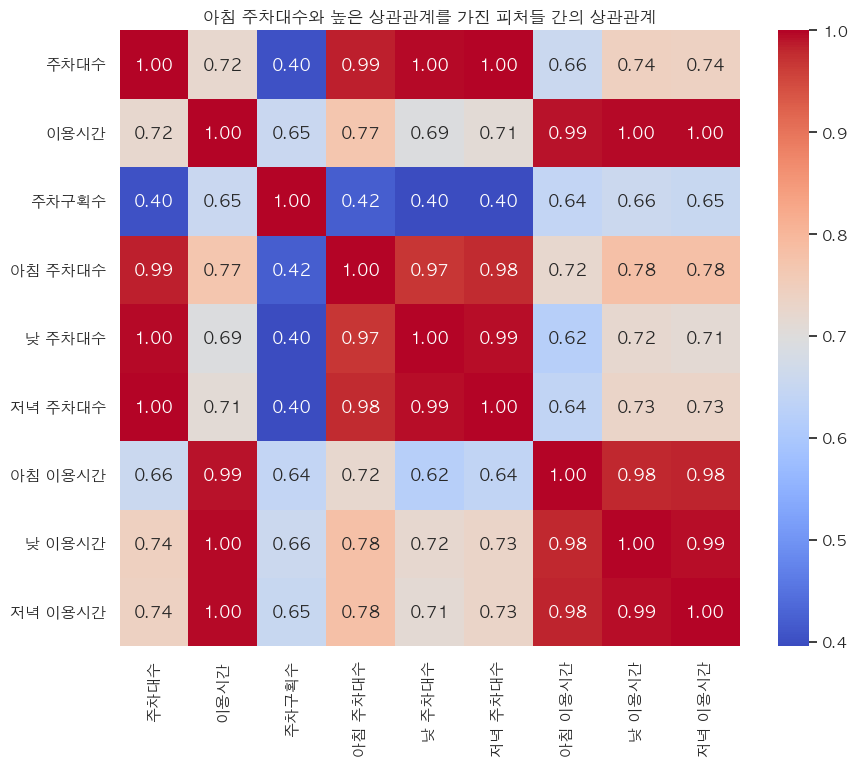

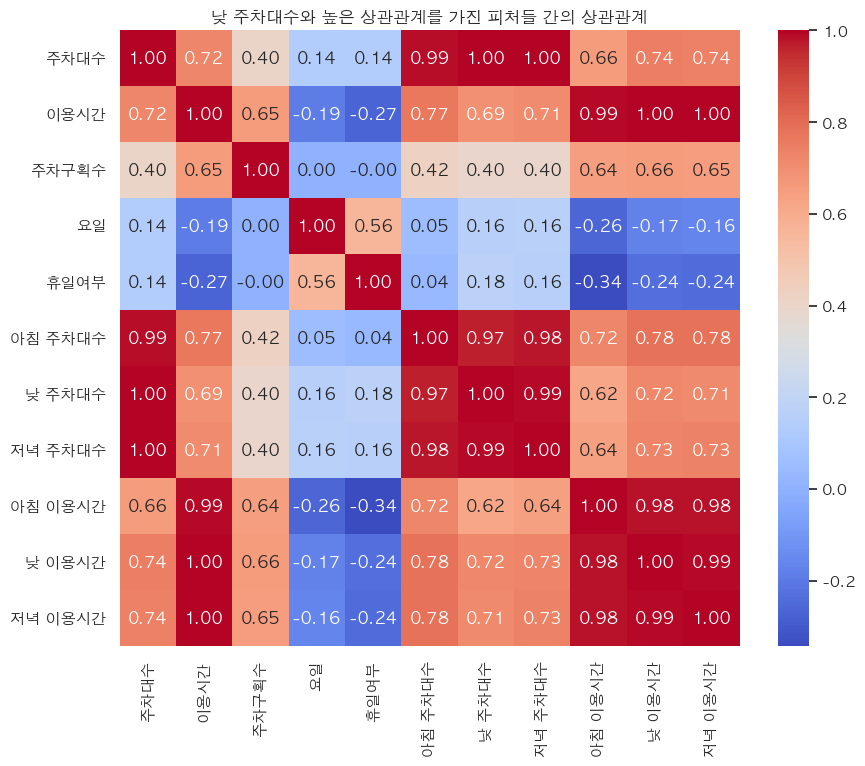

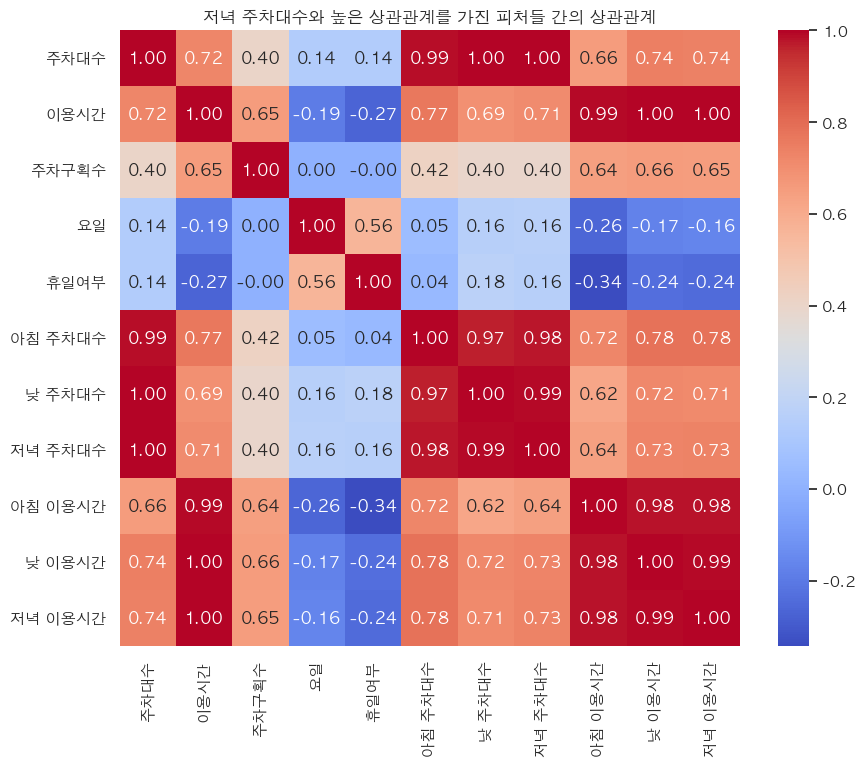

In [136]:
# 숫자형 데이터만 선택
numeric_df = df.select_dtypes(include=['number'])

# 타겟 변수
targets = ['아침 주차대수', '낮 주차대수', '저녁 주차대수']

# 상관관계 계산 및 시각화
for target in targets:
    # 타겟 변수와의 상관관계 계산
    target_corr = numeric_df.corr()[target]

    # 절대값이 0.1 이상인 피처들만 선택
    high_corr_features = target_corr[abs(target_corr) >= 0.1].index
    
    # 상관관계 히트맵 그리기
    plt.figure(figsize=(10, 8))
    sns.heatmap(numeric_df[high_corr_features].corr(), annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
    plt.title(f'{target}와 높은 상관관계를 가진 피처들 간의 상관관계')
    plt.show()

### 아침, 낮, 저녁 주차대수와 관련 변수 
1. 아침 주차대수            
- 주차대수, 이용시간과 높은 상관관계를 가짐         
- 주차구획수는 상대적으로 낮은 상관관계를 가짐          
**아침 주차대수는 전체 주차대수와 밀접한 관련이 있으며, 이용시간 역시 중요한 영향을 미치는 변수로 확인됨.**         

2. 낮 주차대수          
- 주차대수, 이용시간과 높은 상관관계를 가짐         
- 요일, 휴일여부와는 약한 상관성을 나타냄.          
**낮 시간대 주차대수는 다른 시간대(아침,저녁)와 밀접하게 연계되어 있으며, 이용시간이 주차량 예측에 중요한 변수로 작용.**            

3. 저녁 주차대수            
= 주차대수, 아침 주차대수, **낮 주차대수**와 유사하게 높은 상관관계를 가짐.         
- 이용시간과의 상관관계도 상당히 높음(0.71).                
- 요일(0.16), 휴일여부(0.16)와는 상대적으로 낮은 상관관계를 가짐.           
**저녁 주차대수는 시간대별 주차대수(아침, 낮)와 밀접하게 연결되어 있으며, 주차 특성이 시간대에 걸쳐 연속적으로 유지되는 경향이 있음.**          

4. 결론         
**시간대별 주차대수는 전체 주차대수와 이용시간과 강한 상관관계를 가지며, 이는 시간대별 주차 특성이 주차량 예측에 중요한 역할을 함.**                            
**요일 및 휴일여부는 시간대별 주차대수와 약한 상관관계를 가지지만, 주차 패턴 변화에 유의미한 영향을 미칠 가능성이 있으므로 보조 변수로 고려할 수 있음.**          

이용시간은 사용자가 입력할 수 없으므로 이용시간 예측 모델을 생성하는 것도 고려해 보아야할 것 같음.

### 시간대별 이용시간의 분포

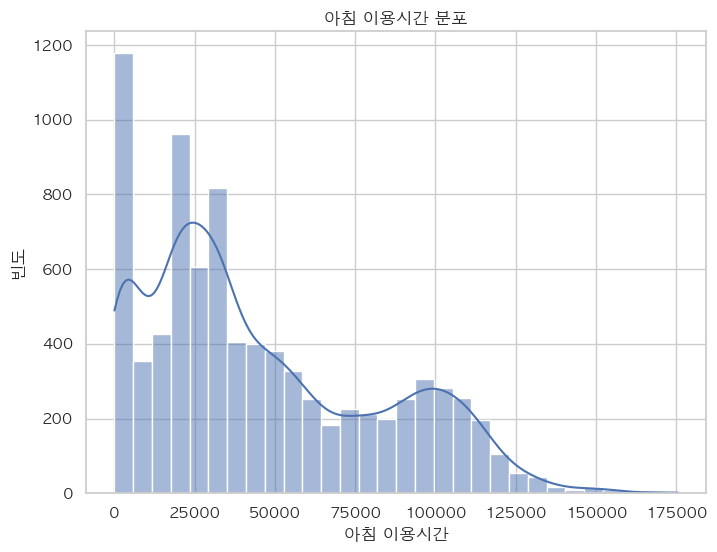

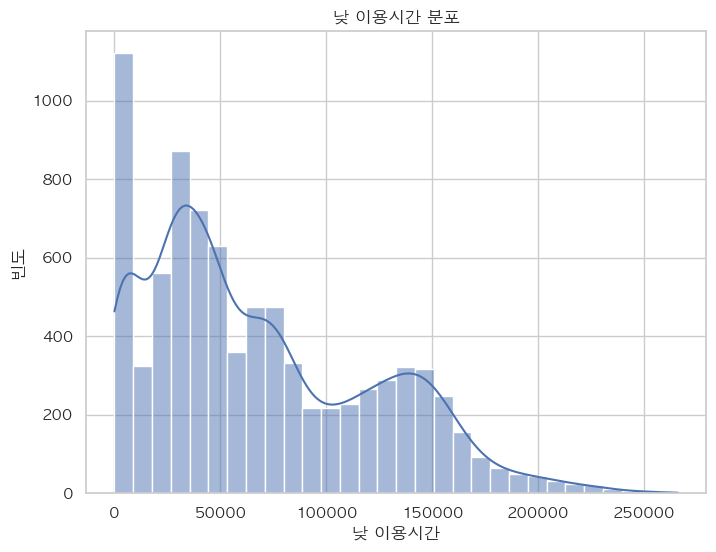

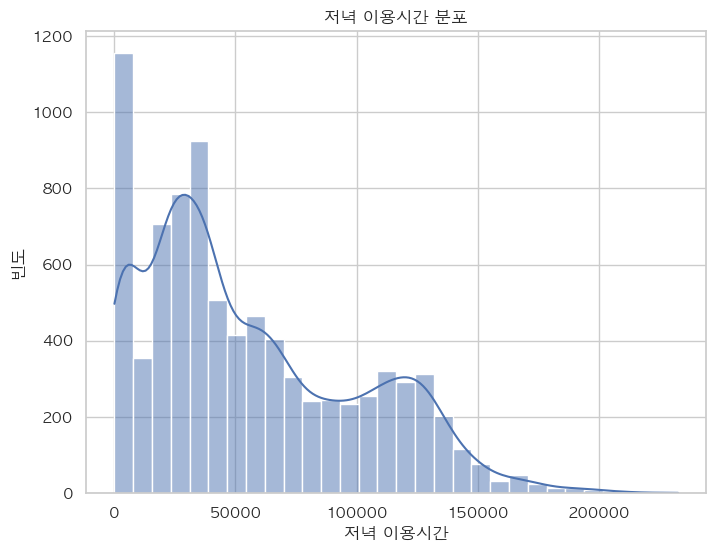

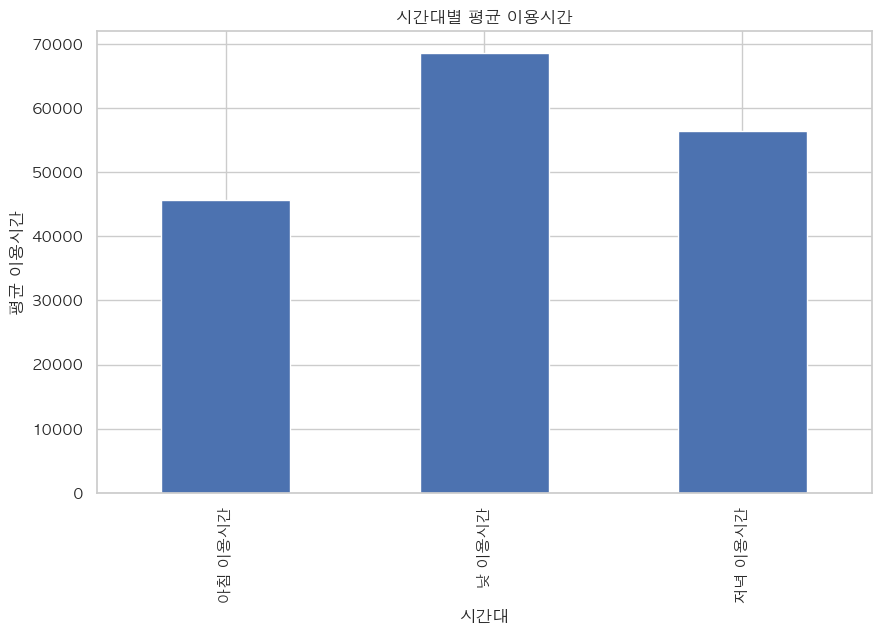

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시간대별 이용시간 평균
time_usage_means = df[['아침 이용시간', '낮 이용시간', '저녁 이용시간']].mean()

# 히스토그램: 시간대별 이용시간 분포
for col in ['아침 이용시간', '낮 이용시간', '저녁 이용시간']:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'{col} 분포')
    plt.xlabel(col)
    plt.ylabel('빈도')
    plt.show()

# 시간대별 평균 이용시간 시각화
plt.figure(figsize=(10, 6))
time_usage_means.plot(kind='bar')
plt.title('시간대별 평균 이용시간')
plt.xlabel('시간대')
plt.ylabel('평균 이용시간')
plt.show()


시간대별 이용시간 분포
- 아침, 낮, 저녁 이용시간의 히스토그램을 통해, 아침은 낮은 값(0~50,000)에서 높은 빈도를 보였고, 낮과 저녁은 더 높은 값으로 분포가 확장되었습니다.           
- 아침보다 낮 이용시간이 평균적으로 더 길며, 이는 하루 중 낮 시간대의 주차장이 가장 많이 사용된다는 것을 의미합니다.            
**결론: 낮 시간대는 예측 모델에서 중요한 피처로 고려되어야 하며, 아침과 저녁도 보조적인 정보로 포함될 수 있습니다**

### 요일별 이용시간 분석

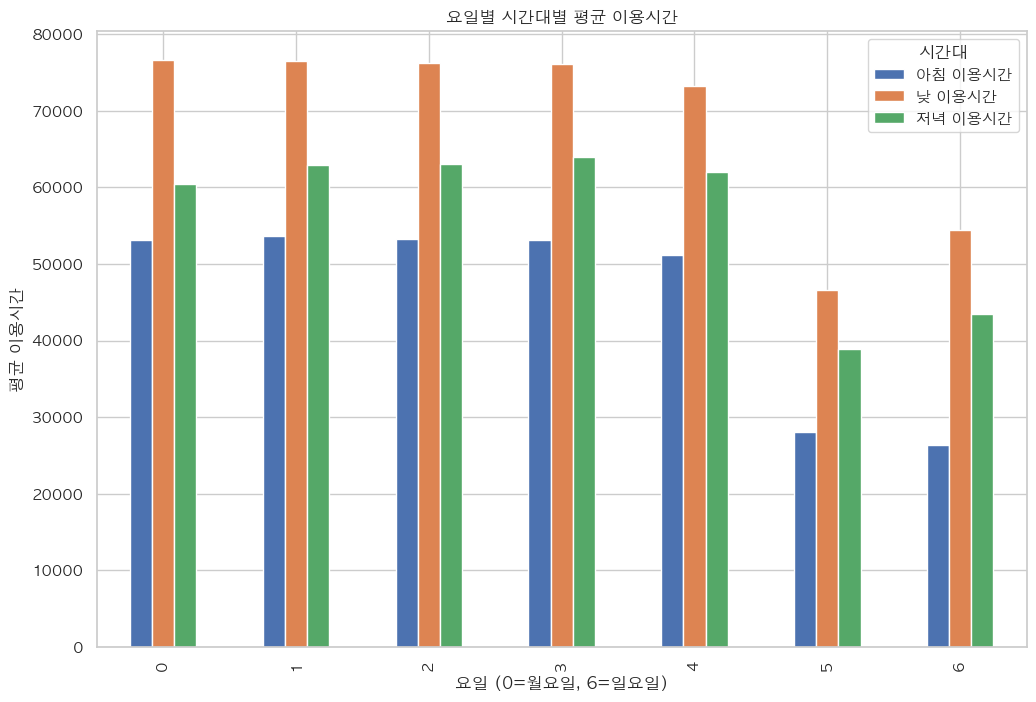

In [138]:
# 요일별 시간대별 평균 이용시간 계산
weekday_usage = df.groupby('요일')[['아침 이용시간', '낮 이용시간', '저녁 이용시간']].mean()

# 요일별 시간대별 평균 이용시간 시각화
weekday_usage.plot(kind='bar', figsize=(12, 8))
plt.title('요일별 시간대별 평균 이용시간')
plt.xlabel('요일 (0=월요일, 6=일요일)')
plt.ylabel('평균 이용시간')
plt.legend(title='시간대')
plt.show()


시간대별 평균 이용시간
- 낮 이용시간이 평균적으로 가장 길었으며, 아침과 저녁은 상대적으로 낮은 값을 보였습니다.                
- 이는 낮 시간대의 교통량과 방문객 수가 많아지는 경향을 반영하는 것으로 보입니다.           
**결론: 낮 이용시간은 주요 피처로 포함되며, 아침과 저녁은 비교적 보조적 역할을 할 수 있습니다.**        

### 휴일 여부에 따른 이용시간 비교

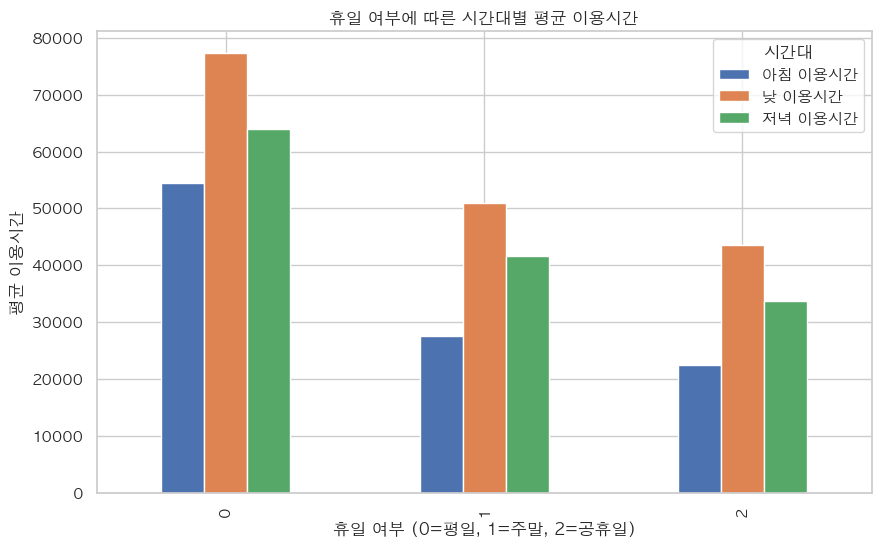

In [139]:
# 휴일 여부별 시간대별 평균 이용시간 계산
holiday_usage = df.groupby('휴일여부')[['아침 이용시간', '낮 이용시간', '저녁 이용시간']].mean()

# 시각화
holiday_usage.plot(kind='bar', figsize=(10, 6))
plt.title('휴일 여부에 따른 시간대별 평균 이용시간')
plt.xlabel('휴일 여부 (0=평일, 1=주말, 2=공휴일)')
plt.ylabel('평균 이용시간')
plt.legend(title='시간대')
plt.show()


요일별 시간대별 평균 이용시간
- 요일별 분석에서는 주말(토요일과 일요일)의 이용시간이 평일보다 낮게 나타났습니다.              
- 이는 데이터가 특정 기간에 집중되었거나 주말의 일부 시간대에 주차장이 충분히 활용되지 않았기 때문일 수 있습니다.           
- 그러나 일반적인 추세와 다르므로 데이터 수집 과정 또는 특정 변수(날씨, 행사 등)를 추가 검토해야 합니다.            
**결론: 주말 데이터를 별도로 탐색하거나, 날씨와 같은 외부 요인을 포함하여 요일별 이상치를 확인해야 합니다.**        

### 주차대수와 이용시간 간 상관관계 분석

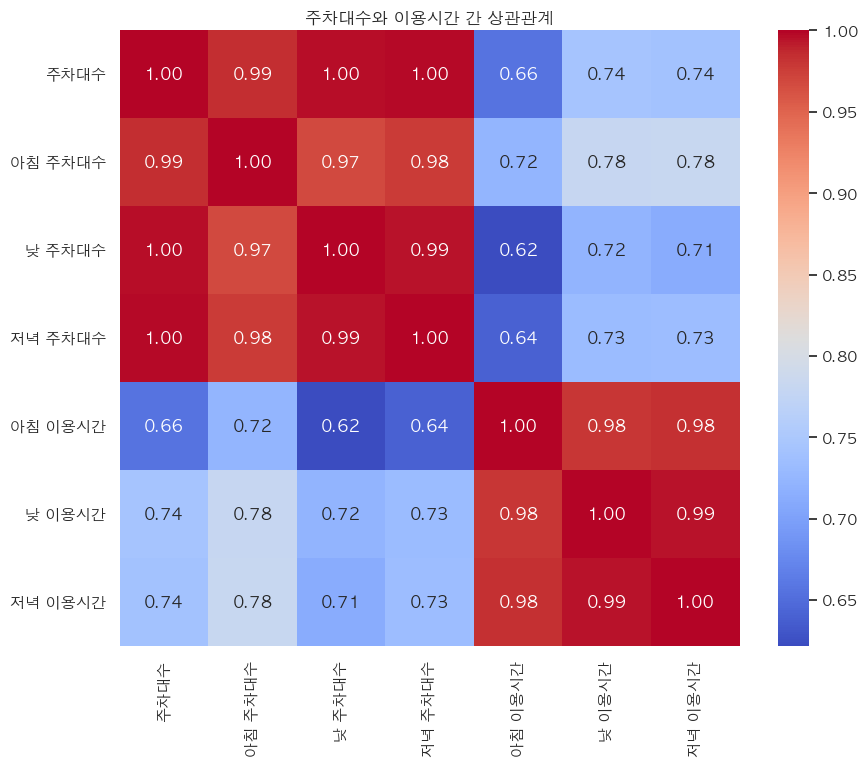

In [140]:
# 상관관계 계산
corr_matrix = df[['주차대수', '아침 주차대수', '낮 주차대수', '저녁 주차대수', '아침 이용시간', '낮 이용시간', '저녁 이용시간']].corr()

# 히트맵으로 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('주차대수와 이용시간 간 상관관계')
plt.show()


주차대수와 이용시간 간 상관관계
- 전체 주차대수와 낮 이용시간의 상관관계는 0.74로 가장 높았습니다.          
- 아침과 저녁 주차대수 역시 낮은 상관관계를 보이지는 않지만, 상대적으로 낮 이용시간과 더 높은 상관성을 보였습니다.          
결론: 주차대수와 이용시간은 밀접한 상관관계를 가지며, 시간대별 주차대수는 예측 모델에서 중요한 피처가 될 것입니다.

# 주요 피처 선정 이유
    요일:
    요일에 따라 이용시간과 주차 패턴이 달라 혼잡도에 영향을 미침.

    휴일여부:
    평일, 주말, 공휴일의 주차 이용 패턴이 다르게 나타남.

    주차장명:
    주차장별로 주차구획수와 이용 특성이 다름.

    연도, 월, 일:
    계절적 요인과 시간 흐름에 따른 주차 이용 패턴 반영.

### 이용시간 포함여부
이용시간은 모델 입력 피처에 포함되지 않지만, 중간 예측 변수로 사용.

왜 이용시간은 입력 피처가 아닌가에 대하여
- 사용자가 직접 입력할 수 없는 값이기 때문에 모델 입력 피처로 사용 불가.

활용성:
1. 이용시간 예측
- 요일, 휴일여부, 주차장명 등의 입력값으로 이용시간을 예측
2. 시간대별 주차대수 예측
- 예측된 이용시간을 기반으로 아침 주차대수, 낮 주차대수, 저녁 주차대수를 계산.

**결론**
- 이용시간은 최종 타겟 변수(아침, 낮, 저녁 주차대수)를 예측하기 위한 중간 변수로 사용됨.
- 입력 피처는 사용자가 입력할 수 있는 변수로 제한되고, 이용시간은 예측 과정에서 자동 생성.

---
# 모델링

## 모델링 목표
    타겟 변수:
    시간대별 주차 대수: 아침 주차대수, 낮 주차대수, 저녁 주차대수.

    입력 피처:
    요일, 휴일여부, 주차장명, 지구별, 연도, 월, 일.

    결과 출력:
    예측된 시간대별 주차 대수 기반으로 혼잡도(여유, 보통, 혼잡, 만차)를 제공

### 혼잡도 계산 기준
    여유: 예측 주차대수 ≤ 50% * 주차구획수
    보통: 50% < 예측 주차대수 ≤ 80% * 주차구획수
    혼잡: 80% < 예측 주차대수 ≤ 100% * 주차구획수
    만차: 예측 주차대수 > 100% * 주차구획수

> 이용시간이 높은 상관관계를 보이나 사용자가 주차 이용시간을 입력하기는 어려움으로 예측 이용시간으로 주차대수를 예측해야 함.

### 데이터 준비

In [142]:
# 입력 피처 및 타겟 변수 설정
features = ['요일', '휴일여부', '주차장명', '연도', '월', '일']
target_usage = '이용시간'
targets_parking = ['아침 주차대수', '낮 주차대수', '저녁 주차대수']

# 범주형 데이터 처리
X = pd.get_dummies(df[features])
y_usage = df[target_usage]
y_parking = df[targets_parking]


### 이용시간 예측

In [143]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y_usage, test_size=0.2, random_state=42)

# 모델 학습
usage_model = RandomForestRegressor(random_state=42)
usage_model.fit(X_train, y_train)

# 예측
predicted_usage = usage_model.predict(X_test)

# 훈련 및 테스트 점수 출력
train_score_usage = usage_model.score(X_train, y_train)
test_score_usage = usage_model.score(X_test, y_test)

print(f"이용시간 예측 모델 - 훈련 점수: {train_score_usage:.2f}")
print(f"이용시간 예측 모델 - 테스트 점수: {test_score_usage:.2f}")

이용시간 예측 모델 - 훈련 점수: 0.98
이용시간 예측 모델 - 테스트 점수: 0.84


### 시간대별 주차대수 예측 모델

In [144]:
from sklearn.multioutput import MultiOutputRegressor

# 예측된 이용시간 추가
df['예측 이용시간'] = usage_model.predict(X)

# 새로운 입력 피처 설정
features_with_usage = ['예측 이용시간'] + features
X_parking = pd.get_dummies(df[features_with_usage])

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_parking, y_parking, test_size=0.2, random_state=42)

# MultiOutputRegressor로 학습
parking_model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
parking_model.fit(X_train, y_train)

# 예측
predicted_parking = parking_model.predict(X_test)

# 훈련 및 테스트 점수 출력
train_score_parking = parking_model.score(X_train, y_train)
test_score_parking = parking_model.score(X_test, y_test)

print(f"시간대별 주차대수 예측 모델 - 훈련 점수: {train_score_parking:.2f}")
print(f"시간대별 주차대수 예측 모델 - 테스트 점수: {test_score_parking:.2f}")


시간대별 주차대수 예측 모델 - 훈련 점수: 0.99
시간대별 주차대수 예측 모델 - 테스트 점수: 0.83


### 혼잡도 계산

In [147]:
# 혼잡도 계산 함수
def calculate_congestion(parking_count, capacity):
    ratio = parking_count / capacity
    if ratio <= 0.5:
        return '여유'
    elif ratio <= 0.8:
        return '보통'
    elif ratio <= 1.0:
        return '혼잡'
    else:
        return '만차'

# 예측
predicted_parking_full = parking_model.predict(X_parking)

# 혼잡도 계산
for time, idx in zip(['아침', '낮', '저녁'], range(3)):
    df[f'{time} 혼잡도'] = [
        calculate_congestion(p, c) 
        for p, c in zip(predicted_parking_full[:, idx], df['주차구획수'])
    ]

# 결과 확인
result = df[['날짜', '주차장명', '예측 이용시간', '아침 혼잡도', '낮 혼잡도', '저녁 혼잡도']]
print(result.head())

          날짜     주차장명    예측 이용시간 아침 혼잡도 낮 혼잡도 저녁 혼잡도
0 2024-09-30  여의도3주차장  362661.90     보통    보통     보통
1 2024-09-30  여의도5주차장  102177.44     보통    혼잡     혼잡
2 2024-09-30  여의도2주차장  187843.63     만차    만차     만차
3 2024-09-30  여의도1주차장  384334.23     만차    만차     만차
4 2024-09-30  여의도4주차장   62764.86     여유    여유     여유
